<a href="https://colab.research.google.com/github/laicsiifes/question_generation_pt/blob/main/Notebook/gtp40_analysis_qg_concurrent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT4o batch analysis
Batches call to OPENAI API.
How to use
- Define openapi token
- define quantity of token. This depends on which tier you are under into openAI Platform. Currently, we are using 790000 TPM.

In [1]:
!pip install  transformers datasets openai[async] nest_asyncio tiktoken aiofiles

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.5/362.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfu

In [2]:
# mount gdrive
from google.colab import drive
import json
import glob
import pandas as pd
import tiktoken
import json
import re
import pandas as pd
from openai import OpenAI
# get env from colab
from google.colab import userdata
from tqdm.notebook import tqdm
import pickle
import os
from openai import AsyncOpenAI
import asyncio
import time
import json
import aiofiles
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:


prompt_2 = """
    Analise a pergunta fornecida pelo usuário e determine se ela pode ser respondida com base no contexto fornecido.
    Se a pergunta puder ser respondida, forneça a resposta com base no contexto.
    Se a pergunta não puder ser respondida, responda com "Não" e não forneça nenhum contexto adicional.
    A saída deve ser um JSON no seguinte formato:

    {
      "is_question_valid": true/false,
      "response": "..."
    }

    Onde "is_question_valid" é true se a pergunta puder ser respondida com base no contexto, e false caso contrário.
    O campo "response" deve conter a resposta à pergunta ou "Não" se a pergunta não puder ser respondida.

    Exemplo 1:

    Contexto:
    O Relatório financeiro anual da empresa detalha receitas, despesas e lucro líquido de R$ 15 bilhões no ano fiscal.

    Pergunta:
    Qual foi o lucro líquido da empresa no ano fiscal?

    Saída:
    {
      "is_question_valid": true,
      "response": "O lucro líquido da empresa no ano fiscal foi de R$ 15 bilhões."
    }

    Exemplo 2:
    Contexto:
    João tirou nota sete.

    Pergunta:
    Qual foi a nota do Carlos?

    Saída:
    {
      "is_question_valid": false,
      "response": "Não"
    }

    Exemplo 3:
    Contexto:
    O filme "Aventuras no Espaço" estreou nos cinemas no dia 15 de março de 2023. Dirigido por Maria Silva, o longa-metragem arrecadou 50 milhões de dólares em seu fim de semana de estreia.

    Pergunta:
    Quando o filme "Aventuras no Espaço" estreou?

    Saída:
    {
      "is_question_valid": true,
      "response": "O filme \"Aventuras no Espaço\" estreou nos cinemas no dia 15 de março de 2023."
    }

    Exemplo 4:
    Contexto:
    A receita anual da empresa XYZ cresceu 15% em 2022, atingindo 100 milhões de dólares.

    Pergunta:
    Qual foi o lucro líquido da empresa XYZ em 2022?

    Saída:
    {
      "is_question_valid": false,
      "response": "Não"
    }

    Exemplo 5:
    Contexto:
    O novo modelo de smartphone da TechCorp possui uma tela de 6,5 polegadas, 128GB de armazenamento e uma bateria de 4500mAh.

    Pergunta:
    Qual é o tamanho da tela do novo smartphone da TechCorp?

    Saída:
    {
      "is_question_valid": true,
      "response": "O tamanho da tela do novo smartphone da TechCorp é de 6,5 polegadas."
    }

"""
def get_prompt(question, context):
  prompt_string = """
    Contexto:
    {context}

    Pergunta:
    {question}
    """
  prompt_string = prompt_string.replace("{question}", question)
  prompt_string = prompt_string.replace("{context}", context)
  return prompt_string


In [4]:
key = userdata.get('OPENAI_KEY')
client = OpenAI(api_key=key)
MODEL = 'gpt-4o'
def save_checkpoint(progress, filename='checkpoint.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(progress, f)

def load_checkpoint(filename='checkpoint.pkl'):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)
    return None
def extract_json(response):
    json_match = re.search(r'\{.*\}', response, re.DOTALL)
    if json_match:
        json_string = json_match.group()
        try:
            json_data = json.loads(json_string)
            return json.dumps(json_data, ensure_ascii=False, indent=2)
        except json.JSONDecodeError:
            return "Error: Invalid JSON format"
    else:
        return "Error: No JSON found in the response"

# Token counter
def num_tokens_from_messages(messages, model=MODEL):
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        print("Warning: model not found. Using cl100k_base encoding.")
        encoding = tiktoken.get_encoding("cl100k_base")

    num_tokens = 0
    for message in messages:
        num_tokens += 4  # Every message follows <im_start>{role/name}\n{content}<im_end>\n
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":  # If there's a name, the role is omitted
                num_tokens -= 1  # Role is always required and always 1 token
    num_tokens += 2  # Every reply is primed with <im_start>assistant
    return num_tokens

# Token-based rate limiter class
class TokenRateLimiter:
    def __init__(self, max_tokens, period):
        self.max_tokens = max_tokens
        self.period = period
        self.last_reset = time.time()
        self.tokens_used = 0
        self.lock = asyncio.Lock()

    async def wait_if_needed(self, tokens):
        async with self.lock:
            current_time = time.time()
            time_passed = current_time - self.last_reset
            if time_passed >= self.period:
                self.tokens_used = 0
                self.last_reset = current_time
            elif self.tokens_used + tokens > self.max_tokens:
                wait_time = self.period - time_passed
                print(f"Rate limit reached. Waiting for {wait_time:.2f} seconds.")
                await asyncio.sleep(wait_time)
                self.tokens_used = 0
                self.last_reset = time.time()
            self.tokens_used += tokens


def count_qg_model_occurrences(df):
    # Check if 'qg_model' column exists in the DataFrame
    if 'qg_model' not in df.columns:
        raise ValueError("The DataFrame does not contain a 'qg_model' column")

    # Count occurrences of each unique value in 'qg_model' column
    qg_model_counts = df['qg_model'].value_counts()

    # Convert the result to a DataFrame for better readability
    result_df = qg_model_counts.reset_index()
    result_df.columns = ['qg_model', 'count']

    # Sort the result by count in descending order
    result_df = result_df.sort_values('count', ascending=False)

    return result_df

In [5]:


# Function to write a single result to JSONLines file
async def write_to_jsonl(file_path, data):
    async with aiofiles.open(file_path, 'a', encoding='utf-8') as f:
        await f.write(json.dumps(data, ensure_ascii=False) + '\n')

# Asynchronous GPT call function with token-based rate limiting and JSON writing
async def gpt_call_async(client, messages, rate_limiter, jsonl_file, metadata):
    token_count = num_tokens_from_messages(messages)
    await rate_limiter.wait_if_needed(token_count)

    try:
        response = await client.chat.completions.create(
            model=MODEL,
            messages=messages
        )
        response_content = response.choices[0].message.content

        # Write result to JSONLines file
        result = {
            'qg_model': metadata['qg_model'],
            'type': metadata['type'],
            'question': metadata['question'],
            'context': metadata['context'],
            'prompt': metadata['prompt'],
            'llm_name': MODEL,
            'llm_response': response_content,
            'json_response': extract_json(response_content),
            'question_id': metadata['id']
        }

        await write_to_jsonl(jsonl_file, result)

        return response_content
    except Exception as e:
        print(f"Error calling {MODEL}: {e}")
        return None

# Function to create batches based on token count
def create_token_batches(tasks, max_tokens, prompt_2):
    batches = []
    current_batch = []
    current_tokens = 0

    for task in tasks:
        messages = [
            {"role": "system", "content": prompt_2},
            {"role": "user", "content": task[3]}
        ]
        task_tokens = num_tokens_from_messages(messages)
        if current_tokens + task_tokens > max_tokens and current_batch:
            batches.append(current_batch)
            current_batch = []
            current_tokens = 0
        current_batch.append(task)
        current_tokens += task_tokens

    if current_batch:
        batches.append(current_batch)
    return batches

# Main processing function (now with asynchronous batching and JSONLines writing)
async def process_files_async(jsonl_file, file_list, start_index=0, filter_dataset=[]):
    print(f"Total files: {len(file_list)}")
    key = userdata.get('OPENAI_KEY')
    async_client = AsyncOpenAI(api_key=key)
    max_tokens = 700000
    rate_limiter = TokenRateLimiter(max_tokens=max_tokens, period=60)


    all_tasks = []
    for file_index, f in enumerate(file_list[start_index:], start=start_index):
        df = pd.read_json(f)
        if filter_dataset:
            df = df[df['id'].isin(filter_dataset)]

        for index, row in df.iterrows():
            prompt = get_prompt(row['generated_question'], row['context'])
            all_tasks.append((file_index, index, row, prompt, f))

    # Create batches based on token count
    batches = create_token_batches(all_tasks, max_tokens, prompt_2)
    print(f"Total batches: {len(batches)} using max_token = {max_tokens}. Will start requests")
    total_processed = 0
    for batch_index, batch in enumerate(tqdm(batches, desc="Processing batches")):
        tasks = []
        for task in batch:
            messages = [
                {"role": "system", "content": prompt_2},
                {"role": "user", "content": task[3]}
            ]
            metadata = {
                'qg_model': os.path.basename(task[4]),
                'type': os.path.basename(os.path.dirname(task[4])),
                'question': task[2]['generated_question'],
                'context': task[2]['context'],
                'prompt': task[3],
                'id': task[2]['id'],
            }
            tasks.append(gpt_call_async(async_client, messages, rate_limiter, jsonl_file, metadata))

        # Process the batch concurrently
        await asyncio.gather(*tasks)

        total_processed += len(batch)

        # Save checkpoint after each batch
        last_task = batch[-1]
        print(f"Saving checkpoint: Batch {batch_index}, File {last_task[0]}, Row {last_task[1]}")
        save_checkpoint({'file_index': last_task[0], 'row_index': last_task[1]})

    return total_processed

# PIRA RUN

In [6]:
from pathlib import Path


file_list = glob.glob('/content/drive/MyDrive/Masters-QG/results/14-08-2024/pira/**/**.json')
print(f"Total files: {len(file_list)}")

checkpoint = load_checkpoint(filename="checkpoint.pira.pkl")
if checkpoint:
    print(f"Resuming from checkpoint: File {checkpoint['file_index']}, Row {checkpoint['row_index']}")
    start_index = checkpoint['file_index']
else:
    start_index = 0


answer_df = pd.DataFrame(columns=['question_id', 'qg_model', 'type', 'question', 'context', 'prompt', 'llm_name', 'llm_response', 'json_response'])

jsonl_file = '/content/results.jsonl'


processed_count = await process_files_async(jsonl_file, file_list, start_index)






Total files: 6
Total files: 6
Total batches: 2 using max_token = 700000. Will start requests


Processing batches:   0%|          | 0/2 [00:00<?, ?it/s]

Saving checkpoint: Batch 0, File 3, Row 42
Rate limit reached. Waiting for 13.21 seconds.
Saving checkpoint: Batch 1, File 5, Row 215


In [7]:
read = pd.read_json('/content/results.jsonl', lines=True)
read.describe()

,qg_model,type,question,context,prompt,llm_name,llm_response,json_response,question_id
count,1296,1296,1296,1296,1296,1296,1296,1296,1296
unique,6,1,1164,175,1164,1,932,924,216
top,ptt5_small_predictions.json,in_ctx_ans_out_question,Quais são as principais características primár...,Como os campos de petróleo offshore estão send...,\n Contexto:\n A descoberta de grandes a...,gpt-4o,"{\n ""is_question_valid"": false,\n ""response""...","{\n ""is_question_valid"": false,\n ""response""...",B2468
freq,216,1296,6,24,6,1296,272,285,6


In [8]:
output_file_path = Path("/content/drive/MyDrive/Masters-QG/results/14-08-2024/gpt-4o/pira/results.csv")

output_file_path.parent.mkdir(parents=True, exist_ok=True)
# Save final results
read.to_csv(output_file_path, index=False)
print("Processing completed and results saved.")


Processing completed and results saved.


In [9]:
print(count_qg_model_occurrences(read))


                         qg_model  count
0     ptt5_small_predictions.json    216
1      ptt5_base_predictions.json    216
2     ptt5_large_predictions.json    216
3  flan_t5_small_predictions.json    216
4   flan_t5_base_predictions.json    216
5  flan_t5_large_predictions.json    216


# Fairytale run


In [10]:
file_list =  glob.glob('/content/drive/MyDrive/Masters-QG/results/14-08-2024/fairytale_pt_br_qa/**/**.json')

checkpoint = load_checkpoint(filename='checkpoint.fairytale.pkl')
if checkpoint:
    print(f"Resuming from checkpoint: File {checkpoint['file_index']}, Row {checkpoint['row_index']}")
    start_index = checkpoint['file_index']
else:
    start_index = 0


answer_df = pd.DataFrame(columns=['question_id', 'qg_model', 'type', 'question', 'context', 'prompt', 'llm_name', 'llm_response', 'json_response'])

jsonl_file = '/content/results_fairytale.jsonl'


processed_count = await process_files_async(jsonl_file, file_list, start_index)




Total files: 6
Total batches: 8 using max_token = 700000. Will start requests


Processing batches:   0%|          | 0/8 [00:00<?, ?it/s]

Saving checkpoint: Batch 0, File 0, Row 803
Saving checkpoint: Batch 1, File 1, Row 613
Rate limit reached. Waiting for 28.20 seconds.
Saving checkpoint: Batch 2, File 2, Row 413
Saving checkpoint: Batch 3, File 3, Row 216
Rate limit reached. Waiting for 30.44 seconds.
Saving checkpoint: Batch 4, File 4, Row 15
Rate limit reached. Waiting for 25.25 seconds.
Saving checkpoint: Batch 5, File 4, Row 819
Saving checkpoint: Batch 6, File 5, Row 628
Rate limit reached. Waiting for 23.88 seconds.
Saving checkpoint: Batch 7, File 5, Row 1006


In [11]:
read_fairy = pd.read_json('/content/results_fairytale.jsonl', lines=True)
output_file_path = Path("/content/drive/MyDrive/Masters-QG/results/14-08-2024/gpt-4o/fairytale_qa_pt_br/results.csv")

output_file_path.parent.mkdir(parents=True, exist_ok=True)
# Save final results
read_fairy.to_csv(output_file_path, index=False)
print("Processing completed and results saved.")

Processing completed and results saved.


In [12]:


count_qg_model_occurrences(read_fairy)

,qg_model,count
0,ptt5_small_predictions.json,1007
1,ptt5_base_predictions.json,1007
2,ptt5_large_predictions.json,1007
3,flan_t5_small_predictions.json,1007
4,flan_t5_base_predictions.json,1007
5,flan_t5_large_predictions.json,1007


# Analysis GPT-4o

In [13]:
import matplotlib.pyplot as plt

def parse_json(text):
    try:
      text = text.replace('\n', '')
      j = extract_json(text)
      j = json.loads(j)
    except:
      j = {}
    return j

def plot_bar(df_pivot):
  ax = df_pivot.plot(kind='bar', stacked=True, figsize=(20, 10), colormap='tab10')
  # Adding labels and title
  plt.xlabel('QG Model')
  plt.ylabel('Count')
  plt.title('Stacked Bar Graph of Question Validity by QG Model')
  plt.legend(title='Is Question Valid', labels=['Invalid', 'Valid'])
  plt.xticks()


  # Annotate counts on the bars
  for i in range(df_pivot.shape[0]):
      total = df_pivot.iloc[i].sum()
      for j, (valid, count) in enumerate(df_pivot.iloc[i].items()):
          if valid:
              ax.text(i, df_pivot.iloc[i, 0] + count / 2, f'{count} ({count / total:.1%})', ha='center', va='center', color='black')
          else:
              ax.text(i, df_pivot.iloc[i, 0] / 2, f'{count} ({count / total:.1%})', ha='center', va='center', color='black')

  plt.show()

def read_results_df(file_path):
  df_analysis = pd.read_csv(file_path)
  df_analysis['normalized_json'] = df_analysis['json_response'].map(parse_json)
  df_analysis['is_question_valid'] = df_analysis['normalized_json'].map(lambda x: x.get('is_question_valid'))
  # group by Type, Model, is_question_valid
  gp = df_analysis.groupby(by=['type', 'qg_model', 'is_question_valid']).size().reset_index(name='count')

  df_grouped = gp.groupby(['type','qg_model', 'is_question_valid']).sum().reset_index()
  df_pivot = df_grouped.pivot(index=['qg_model', 'type'], columns='is_question_valid', values='count')
  df_pivot = df_pivot.sort_values(by=[True], ascending=False)
  return df_pivot

def read_results_df_total(file_path):
    df_analysis = pd.read_csv(file_path)
    df_analysis['normalized_json'] = df_analysis['json_response'].map(parse_json)
    df_analysis['is_question_valid'] = df_analysis['normalized_json'].map(lambda x: x.get('is_question_valid'))

    # group by Type, Model, is_question_valid
    gp = df_analysis.groupby(by=['type', 'qg_model', 'is_question_valid']).size().reset_index(name='count')

    df_grouped = gp.groupby(['type','qg_model', 'is_question_valid']).sum().reset_index()
    df_pivot = df_grouped.pivot(index=['qg_model', 'type'], columns='is_question_valid', values='count')

    # Add total column
    df_pivot['Total'] = df_pivot[True].fillna(0) + df_pivot[False].fillna(0)

    # Calculate percentage of True results
    df_pivot['Percentage True'] = (df_pivot[True] / df_pivot['Total'] * 100).round(2)

    # Sort by Percentage True in descending order
    df_pivot = df_pivot.sort_values(by='Percentage True', ascending=False)

    # Reorder columns
    df_pivot = df_pivot[[True, False, 'Total', 'Percentage True']]

    return df_pivot


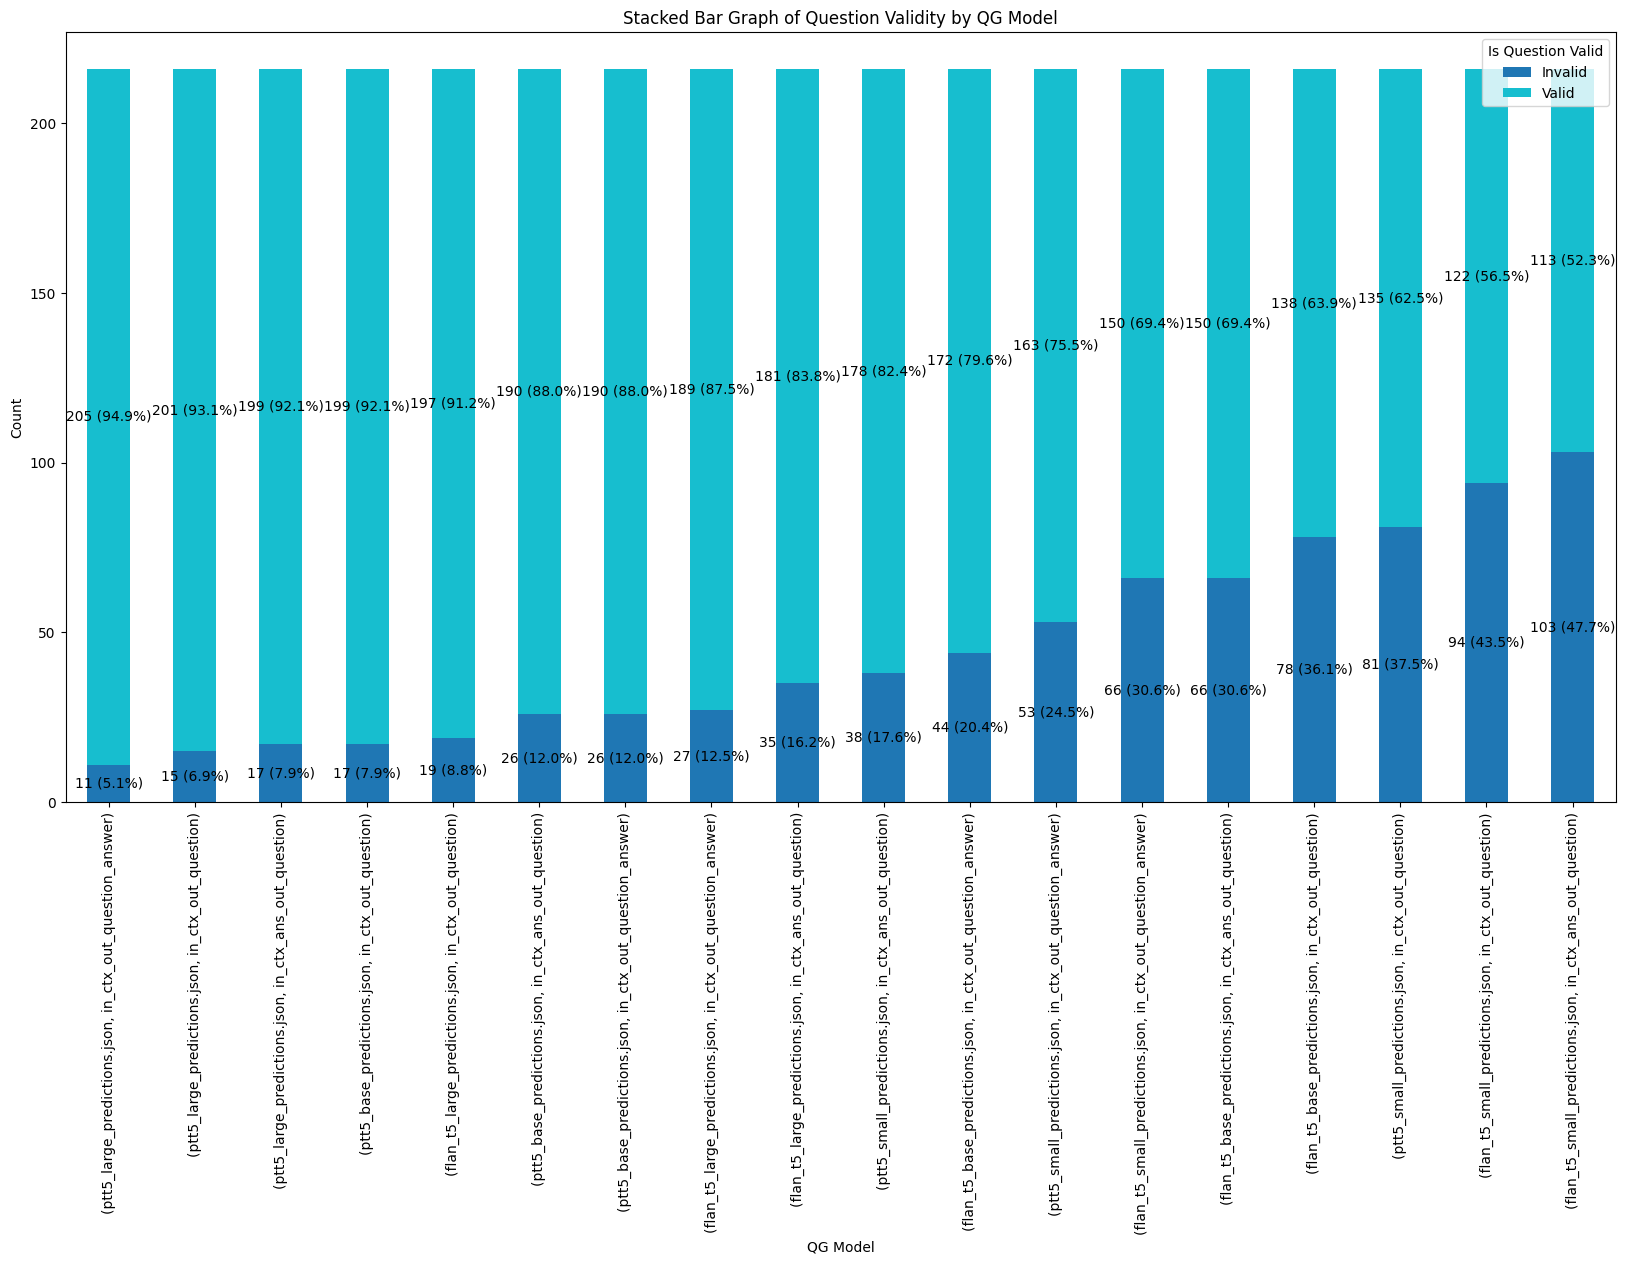

In [14]:
# use _treated version because i manually fixed some errors on json, mainly bc of break lines "\n"
pira_result = '/content/drive/MyDrive/Masters-QG/results/14-08-2024/gpt-4o/pira/results_treated.csv'
df_pira = read_results_df(pira_result)
plot_bar(df_pira)

In [15]:
df_pira_total = read_results_df_total(pira_result)
df_pira_total

is_question_valid                                          True  False  Total  \
qg_model                       type                                             
ptt5_large_predictions.json    in_ctx_out_question_answer   205     11    216   
                               in_ctx_out_question          201     15    216   
                               in_ctx_ans_out_question      199     17    216   
ptt5_base_predictions.json     in_ctx_out_question          199     17    216   
flan_t5_large_predictions.json in_ctx_out_question          197     19    216   
ptt5_base_predictions.json     in_ctx_ans_out_question      190     26    216   
                               in_ctx_out_question_answer   190     26    216   
flan_t5_large_predictions.json in_ctx_out_question_answer   189     27    216   
                               in_ctx_ans_out_question      181     35    216   
ptt5_small_predictions.json    in_ctx_ans_out_question      178     38    216   
flan_t5_base_predictions.json  in_ctx_out_question_answer   172     44    216   
ptt5_small_predictions.json    in_ctx_out_question_answer   163     53    216   
flan_t5_small_predictions.json in_ctx_out_question_answer   150     66    216   
flan_t5_base_predictions.json  in_ctx_ans_out_question      150     66    216   
                               in_ctx_out_question          138     78    216   
ptt5_small_predictions.json    in_ctx_out_question          135     81    216   
flan_t5_small_predictions.json in_ctx_out_question          122     94    216   
                               in_ctx_ans_out_question      113    103    216   

is_question_valid                                          Percentage True  
qg_model                       type                                         
ptt5_large_predictions.json    in_ctx_out_question_answer            94.91  
                               in_ctx_out_question                   93.06  
                               in_ctx_ans_out_question               92.13  
ptt5_base_predictions.json     in_ctx_out_question                   92.13  
flan_t5_large_predictions.json in_ctx_out_question                   91.20  
ptt5_base_predictions.json     in_ctx_ans_out_question               87.96  
                               in_ctx_out_question_answer            87.96  
flan_t5_large_predictions.json in_ctx_out_question_answer            87.50  
                               in_ctx_ans_out_question               83.80  
ptt5_small_predictions.json    in_ctx_ans_out_question               82.41  
flan_t5_base_predictions.json  in_ctx_out_question_answer            79.63  
ptt5_small_predictions.json    in_ctx_out_question_answer            75.46  
flan_t5_small_predictions.json in_ctx_out_question_answer            69.44  
flan_t5_base_predictions.json  in_ctx_ans_out_question               69.44  
                               in_ctx_out_question                   63.89  
ptt5_small_predictions.json    in_ctx_out_question                   62.50  
flan_t5_small_predictions.json in_ctx_out_question                   56.48  
                               in_ctx_ans_out_question               52.31

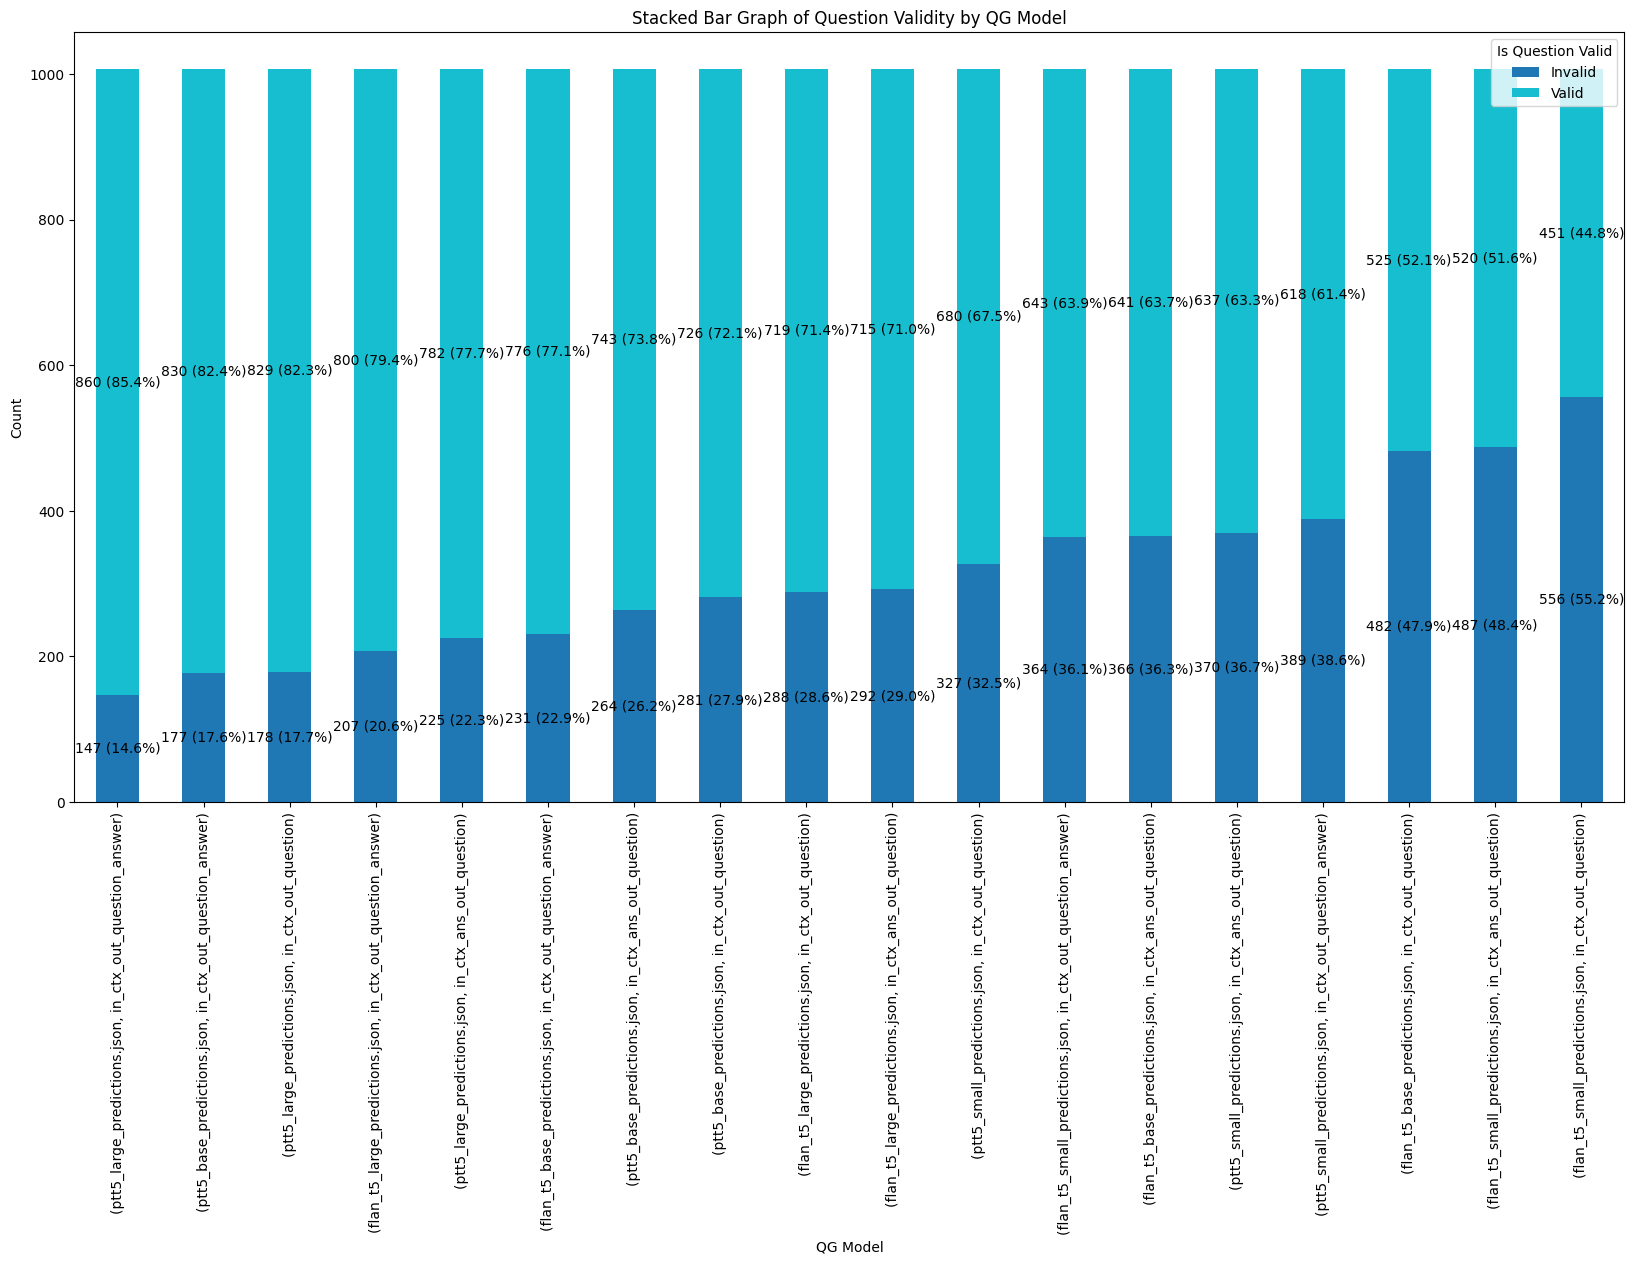

In [16]:
fairy_results = '/content/drive/MyDrive/Masters-QG/results/14-08-2024/gpt-4o/fairytale_qa_pt_br/results_treated.csv'
df_fairy = read_results_df(fairy_results)
plot_bar(df_fairy)

In [17]:
fairy_results_total = read_results_df_total(fairy_results)
fairy_results_total

is_question_valid                                          True  False  Total  \
qg_model                       type                                             
ptt5_large_predictions.json    in_ctx_out_question_answer   860    147   1007   
ptt5_base_predictions.json     in_ctx_out_question_answer   830    177   1007   
ptt5_large_predictions.json    in_ctx_out_question          829    178   1007   
flan_t5_large_predictions.json in_ctx_out_question_answer   800    207   1007   
ptt5_large_predictions.json    in_ctx_ans_out_question      782    225   1007   
flan_t5_base_predictions.json  in_ctx_out_question_answer   776    231   1007   
ptt5_base_predictions.json     in_ctx_ans_out_question      743    264   1007   
                               in_ctx_out_question          726    281   1007   
flan_t5_large_predictions.json in_ctx_out_question          719    288   1007   
                               in_ctx_ans_out_question      715    292   1007   
ptt5_small_predictions.json    in_ctx_out_question          680    327   1007   
flan_t5_small_predictions.json in_ctx_out_question_answer   643    364   1007   
flan_t5_base_predictions.json  in_ctx_ans_out_question      641    366   1007   
ptt5_small_predictions.json    in_ctx_ans_out_question      637    370   1007   
                               in_ctx_out_question_answer   618    389   1007   
flan_t5_base_predictions.json  in_ctx_out_question          525    482   1007   
flan_t5_small_predictions.json in_ctx_ans_out_question      520    487   1007   
                               in_ctx_out_question          451    556   1007   

is_question_valid                                          Percentage True  
qg_model                       type                                         
ptt5_large_predictions.json    in_ctx_out_question_answer            85.40  
ptt5_base_predictions.json     in_ctx_out_question_answer            82.42  
ptt5_large_predictions.json    in_ctx_out_question                   82.32  
flan_t5_large_predictions.json in_ctx_out_question_answer            79.44  
ptt5_large_predictions.json    in_ctx_ans_out_question               77.66  
flan_t5_base_predictions.json  in_ctx_out_question_answer            77.06  
ptt5_base_predictions.json     in_ctx_ans_out_question               73.78  
                               in_ctx_out_question                   72.10  
flan_t5_large_predictions.json in_ctx_out_question                   71.40  
                               in_ctx_ans_out_question               71.00  
ptt5_small_predictions.json    in_ctx_out_question                   67.53  
flan_t5_small_predictions.json in_ctx_out_question_answer            63.85  
flan_t5_base_predictions.json  in_ctx_ans_out_question               63.65  
ptt5_small_predictions.json    in_ctx_ans_out_question               63.26  
                               in_ctx_out_question_answer            61.37  
flan_t5_base_predictions.json  in_ctx_out_question                   52.14  
flan_t5_small_predictions.json in_ctx_ans_out_question               51.64  
                               in_ctx_out_question                   44.79

# TODO
- Acrescentar análise dos cenários que geram perguntas e resposta
- analisar manualmente 25% das respostas do GPT ** para o PIRA
- Montar seções dos experimentos e tabelas dos resultados no artigo
- Pensar na avaliação das respostas
- Botar as tabelas no artigo

In [ ]:
df_tst = pd.read_json('/content/drive/MyDrive/Masters-QG/results/14-08-2024/pira/in_ctx_out_question_answer/ptt5_large_predictions.json')
df_tst

,id,context,reference_question,reference_answer,generated_prediction,generated_question,generated_answer
0,B2392,Mudanças na erosão costeira de impacto e mudan...,Onde ocorrerão os principais impactos socioeco...,Os principais impactos socioeconômicos ocorrer...,QUESTION: Quais são as características geomórf...,Quais são as características geomórficas sensí...,
1,B2327,O clima de mudança climática sempre foi uma gr...,Quanto CO2 a mais está sendo emitido em 2019 e...,2.9 giga toneladas,QUESTION: Qual foi a taxa de crescimento das e...,Qual foi a taxa de crescimento das emissões gl...,
2,B2471,Impactos cumulativos das atividades humanas em...,aproximadamente quantas áreas de delta e estuá...,450,QUESTION: Quais são as principais ameaças aos ...,Quais são as principais ameaças aos manguezais?,
3,B2522,Distribuição de benefícios oceânicos e divulga...,Em que setor trabalha a maioria das marinheiras?,balsas e navios de cruzeiro,QUESTION: O que fez com que tantos dos princip...,O que fez com que tantos dos principais operad...,
4,B2518,A distribuição dos benefícios oceânicos e os d...,Em que regiões o turismo internacional está au...,Ásia e Pacífico,QUESTION: Quais são as regiões onde o turismo ...,Quais são as regiões onde o turismo desempenha...,
...,...,...,...,...,...,...,...
211,A1884,Com uma série de descobertas recentes nas área...,O que o levantamento sísmico de cabo rebocado ...,Pretende explorar petróleo pré-sal no Brasil.,QUESTION: Quais são os desafios da exploração ...,Quais são os desafios da exploração do pré-sal?,
212,A783,Com a aplicação de novas tecnologias para proc...,Por que o sal grosso garante uma impermeabilid...,O sal grosso tem porosidade insignificante qua...,QUESTION: Quais são os fenômenos associados ao...,Quais são os fenômenos associados ao sal de ro...,
213,A408,Com a aplicação de novas tecnologias para proc...,Por que a Petrobras está estudando a estratégi...,Porque cavernas abertas por dissolução em cúpu...,QUESTION: Quais são os fenômenos associados ao...,Quais são os fenômenos associados ao sal de ro...,
214,A1898,Com o início global de condições mais complexa...,Quais são as desvantagens de utilizar ondas co...,Ondas convencionais baseadas em tecnologia ult...,QUESTION: Por que a tecnologia de pulso ultras...,Por que a tecnologia de pulso ultrassônico foi...,
